# Spatial extent analysis

Ready to increase the "spatial extent" of your knowledge on this? ... Sorry not my best one.

You will find below concrete methods and detailed tutorials to apply the spatial extent methods to your data and what to do when you encounter specific (potentially problematic) situations.

Note that, by nature, the methodologies you can use to derive thresholds are almost... well... infinite. It really depends on the data you currently have and whether the method you chose is appropriate for it. In `sihnpy`, I chose to integrate two. However, when possible I point out different ways users can adapt their script to adapt the methods for thresholding. Depending on the demand, I will also add more methods in the future.

## Outline

As all other modules in `sihnpy`, some data is included in the package so you can practice the different aspects of the module before moving on to your data. I will first take a moment to describe the data included.

Then, we will jump in the spatial extent. Using the spatial extent for your data is divided in two steps: 

| **Derive thresholds** | **Apply thresholds** |
|:-------|:--------|
| Use a method to establish a singular <br> threshold for each brain region | Apply the thresholds from the first <br> step and compute spatial extent measures |

The thresholds in `sihnpy` are either derived using a **Gaussian mixture modelling** approach, or assume that thresholds were **derived from a normative population**. Both ways will be described in detail below.

## Practice data

In other `sihnpy` modules, real data from a small subset (15) of the PREVENT-AD Open Dataset is used. However, this method was developed using positron emission tomography data, specifically for tau pathology. While it is in the plans for the future to have this data available in the PREVENT-AD, it is currently not available in the data release. Furthermore, real data may not show all of the issues that can arise in using the software.

Have no fear though! I have worked hard to simulate tau-PET data for PREVENT-AD participants so you can have a realistic feel for using this module. As of now, simulated tau positron emission tomography (PET) data is available for the 308 participants of the PREVENT-AD Open dataset. Curious on how this was done or want to understand more about this data? {ref}`Find more details here <2.spex/spex_details:Creating Gaussian simulated data>`

As a quick primer on PET data, the main things you should know when using this data is that the values that are simulated in `sihnpy` are called **Standardized Uptake Ratio Values (SUVR)**. They are a measure of how much of the PET tracer is uptake (i.e., how much pathology there is) in a given brain region compared to the uptake in a reference region that does not accumulate pathology. A SUVR close to or below 1 indicates very low levels of pathology, while higher values represent more and more pathology. Note that the uptake varies between regions, **so thresholds will change depending on the region**.

```{warning}
Note that `sihnpy` provides data to practice using the spatial extent module. While the PREVENT-AD participants are used, the data available for this method **is simulated data** (i.e., the numbers observed are fake; they were randomly generated to fit the purpose of the tutorials). As a general rule for `sihnpy`, and especially for this module, **only use the data provided to help you practice using the module, not to conduct or publish actual research**.
```

## Deriving thresholds
### Introduction to Gaussian mixture modelling (GMM)

The main method proposed by `sihnpy` to derive thresholds is to use **Gaussian mixture modelling (GMM)**. The rationale behind this method is that data points in a dataset belong to a set of gaussian (a.k.a. normal) distributions (a.k.a. distinct populations). GMMs are often referred to as *soft* clustering algorithms; contrary to other clustering algorithms, GMM assign **probabilities that each data point belongs to a specific cluster**. This approach is useful as it allows some granularity on how certain we are that a participant belongs to a specific group. I won't get much more in how GMMs actually work, as it is beyond the purview of `sihnpy`, but I encourage you to go read [`scikit-learn`'s documentation](https://scikit-learn.org/stable/modules/mixture.html#gmm) to learn more.

So GMM find clusters in the data. But what does that have anything to do with finding thresholds?

If you remember the {ref}`introduction to spatial extent <2.spex/spex_intro:Definitions>`, we know that **there are two distinct distribution in the data: people with low values of pathology (tight spread) and people with high values of pathology (spread out).** You can actually observe this visually in the data. Here is an example from the data included in `sihnpy` (i.e., the simulated distribution of tau-PET values in the entorhinal cortex).

INSERT HISTOGRAM IMAGE HERE

Here, there seems to be two distributions in the data: our **low** distribution in green (i.e., "normal") and our **high** distribution in red (i.e., "abnormal"). That's where the thresholding comes in. Since GMMs assign a probability of belonging to either cluster for each participant, we can set a threshold **based on how confident we are that a participant has abnormal values in the marker of interest**. For instance, we could want to be very conservative and say that we want that we will consider abnormal participants who have more than 90% probability of being in the abnormal distribution. Once we decide on the probability we want to set as a threshold, *we need to figure out how does that probability translates to a threshold in our original scale*. To do so, we will try to find the participant who has a probability of being abnormal closest to our threshold, and take their values in the original scale. In the `sihnpy` PREVENT-AD simulated data, this would mean taking the SUVR value of the participant with the probability closest to probability threshold. Below is in illustrated explanation of this process.

INSERT MODIFIED FIGURE 1 FROM MANUSCRIPT

This process is the one detailed below that is implemented in `sihnpy`. If you already have your own thresholds that you wish to apply to the data, you can skip ahead to the {ref}`Applying thresholds <2.spex/spex_module:Applying thresholds>` section.

#### Limitations

GMMs are really great, but they come with some assumptions and limitations.

| **Limitations** | **Possible fixes** |
| Needs a **clear** bimodal distribution | None |
| Large sample size * is needed, particularly <br> when the bimodal distribution is not super evident. | Increase sample size |
| More people with "normal" than "abnormal" values <br> as the algorithm with classify abnormality wrong otherwise | Can be fixed in code, but estimates might not be great <br> regardless |
| `sihnpy` expects higher values to be "abnormal" | Can be fixed in the code or its interpretation |

* Note on bimodal distributions and sample sizes: there is no guidelines on what constitutes an appropriate sample size for a GMM. Some estimates I saw online mention (appropriately) that it depends on the number of parameters used in the clustering, the number of clusters we expect, etc. Furthermore, I don't know that the sample size is the most important characteristic to select the GMM. The most important is really that there is a **clear bimodal** distribution. Having a higher sample may help to make that evident, but clear bimodal distribution at smaller sample sizes may still work. That said, from some estimates I saw in others using this method, samples sizes below 100 are generally not performing super well.


### Steps to derive thresholds with GMMs

Now that we got that out of the way, let's get down to it! I will take you through the steps needed to derive the thresholds using GMM models.

```{important}
You will notice as you explore this module that almost all the functions used to derive clusters with the GMM have some sort of **fix** that can be applied. My recommendation is that when you use the `spex` module try to run all the functions without fixing at first. One of the functions, `spex.gmm_histograms` produces important graphs that can be used to diagnose issues with your data, and you can then make sure that the applying the fixes proposed throughout the module are right for you.
```

#### 1. Get the data

The first step is to get the data we need to generate thresholds for. Fortunately, the `sihnpy.datasets` module already has some ready for us. You can simply download the data using the following:

In [1]:
from sihnpy import datasets

tau_data, regional_thresholds, regional_averages = datasets.pad_spex_input()

The function returns three `pandas.DataFrame` objects. The only one we need for this part is the first one, `tau_data`. The second one, `regional_thresholds` will be discussed for {ref}`applying thresholds from normative populations <2.spex/spex_module:Introduction to pre-determined (normative sample) thresholds>`. The last one will really only be useful if you take an interest in {ref}`simulating your own data <2.spex/spex_module:Simulating data>`.

So for now, let's focus on the `tau_data`. 

In [2]:
tau_data

,sex,test_language,handedness_score,handedness_interpretation,CTX_LH_ENTORHINAL_SUVR,CTX_RH_ENTORHINAL_SUVR,CTX_LH_AMYGDALA_SUVR,CTX_RH_AMYGDALA_SUVR,CTX_LH_FUSIFORM_SUVR,CTX_RH_FUSIFORM_SUVR,CTX_LH_PARAHIPPOCAMPAL_SUVR,CTX_RH_PARAHIPPOCAMPAL_SUVR,CTX_LH_INFERIORTEMPORAL_SUVR,CTX_RH_INFERIORTEMPORAL_SUVR,CTX_LH_MIDDLETEMPORAL_SUVR,CTX_RH_MIDDLETEMPORAL_SUVR,CTX_LH_PRECENTRAL_SUVR,CTX_RH_PRECENTRAL_SUVR,CTX_LH_POSTCENTRAL_SUVR,CTX_RH_POSTCENTRAL_SUVR
participant_id,,,,,,,,,,,,,,,,,,,,
sub-5458966,Male,French,80.00,Right-handed,1.111972,1.120199,1.006147,1.330316,1.322257,1.208377,0.856778,1.149150,1.200685,1.170536,1.136680,1.167629,0.836766,1.181594,0.964623,1.264212
sub-2424540,Female,French,100.00,Right-handed,1.279463,1.238721,1.118358,1.176036,1.064330,1.203981,0.939988,0.965154,1.143115,1.354172,1.189367,1.305499,1.008217,1.265188,0.903880,0.982667
sub-7855613,Female,French,90.00,Right-handed,1.165918,1.074124,1.133187,1.239481,1.057046,1.072006,0.919426,1.051297,1.188624,1.213766,1.178537,1.122608,0.994861,1.224359,1.039233,1.018787
sub-3137570,Male,French,90.00,Right-handed,1.057761,1.058959,1.003114,1.225939,0.950004,1.283570,1.173269,1.108080,1.127921,1.106209,1.007086,1.103633,0.906591,1.236180,0.985742,1.518770
sub-9650197,Female,French,100.00,Right-handed,1.115381,1.106487,1.214722,1.359531,1.346469,1.111211,1.009351,1.172829,1.176183,1.283605,1.016241,1.170783,1.058830,1.208158,0.861014,1.271836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-5336241,Female,French,-30.00,Ambidextrous,1.755116,1.791774,1.892483,0.914250,2.088089,1.693487,1.021844,1.371482,1.587848,2.456752,1.338308,1.571080,0.698112,1.045121,0.558954,0.849271
sub-1002928,Female,French,100.00,Right-handed,1.725995,1.665045,1.567078,1.379281,2.359009,1.743699,1.314826,1.472280,2.517382,1.227152,1.536081,1.932241,1.442845,1.076464,0.985675,0.800467
sub-1283278,Female,English,80.00,Right-handed,1.763810,1.557945,1.831518,1.901642,1.960012,2.085522,1.729197,1.458530,2.390055,2.020771,1.372247,1.800840,1.039855,0.974499,0.910037,0.898030


In this dataset, we see that we have 308 participants from the PREVENT-AD. The first few columns detail their basic demographic information available from the Open Dataset. All the other columns are the simulated tau-PET data. The data was simulated for a total of 16 brain regions: LH/RH indicate which hemisphere the region is from, while the name right after data (e.g., ENTORHINAL) is the name of the brain region we are simulating.

The first step here is to actually remove the demographic information. The GMM code will be applied to all the columns (except the index) that is provided to it. And well... clustering males and females in 2 groups is not really useful for our purposes...

Let's quickly do that using `pandas`

In [3]:
import pandas as pd

tau_data.drop(labels=["sex", "test_language", "handedness_score", "handedness_interpretation"], axis=1, inplace=True) #Axis 1 specifies to drop columns

tau_data

,CTX_LH_ENTORHINAL_SUVR,CTX_RH_ENTORHINAL_SUVR,CTX_LH_AMYGDALA_SUVR,CTX_RH_AMYGDALA_SUVR,CTX_LH_FUSIFORM_SUVR,CTX_RH_FUSIFORM_SUVR,CTX_LH_PARAHIPPOCAMPAL_SUVR,CTX_RH_PARAHIPPOCAMPAL_SUVR,CTX_LH_INFERIORTEMPORAL_SUVR,CTX_RH_INFERIORTEMPORAL_SUVR,CTX_LH_MIDDLETEMPORAL_SUVR,CTX_RH_MIDDLETEMPORAL_SUVR,CTX_LH_PRECENTRAL_SUVR,CTX_RH_PRECENTRAL_SUVR,CTX_LH_POSTCENTRAL_SUVR,CTX_RH_POSTCENTRAL_SUVR
participant_id,,,,,,,,,,,,,,,,
sub-5458966,1.111972,1.120199,1.006147,1.330316,1.322257,1.208377,0.856778,1.149150,1.200685,1.170536,1.136680,1.167629,0.836766,1.181594,0.964623,1.264212
sub-2424540,1.279463,1.238721,1.118358,1.176036,1.064330,1.203981,0.939988,0.965154,1.143115,1.354172,1.189367,1.305499,1.008217,1.265188,0.903880,0.982667
sub-7855613,1.165918,1.074124,1.133187,1.239481,1.057046,1.072006,0.919426,1.051297,1.188624,1.213766,1.178537,1.122608,0.994861,1.224359,1.039233,1.018787
sub-3137570,1.057761,1.058959,1.003114,1.225939,0.950004,1.283570,1.173269,1.108080,1.127921,1.106209,1.007086,1.103633,0.906591,1.236180,0.985742,1.518770
sub-9650197,1.115381,1.106487,1.214722,1.359531,1.346469,1.111211,1.009351,1.172829,1.176183,1.283605,1.016241,1.170783,1.058830,1.208158,0.861014,1.271836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-5336241,1.755116,1.791774,1.892483,0.914250,2.088089,1.693487,1.021844,1.371482,1.587848,2.456752,1.338308,1.571080,0.698112,1.045121,0.558954,0.849271
sub-1002928,1.725995,1.665045,1.567078,1.379281,2.359009,1.743699,1.314826,1.472280,2.517382,1.227152,1.536081,1.932241,1.442845,1.076464,0.985675,0.800467
sub-1283278,1.763810,1.557945,1.831518,1.901642,1.960012,2.085522,1.729197,1.458530,2.390055,2.020771,1.372247,1.800840,1.039855,0.974499,0.910037,0.898030


Ok great! Now we only have our 16 regions with the simulated SUVR tau-PET data. We're ready to start.

#### 2. Estimate the GMM

The first step is to **estimate** a GMM. In `scikit-learn` terms, we need to **fit** a GMM to our data. We also verify whether the data does indeed present a bimodal distribution (i.e., fitting 2-clusters on the data works better than fitting a single cluster).

`sihnpy` makes it super easy to do this without thinking too much. The function `spex.gmm_estimation` only require a `pandas.dataframe` where each column requires a GMM to be applied to. We simply need to run the code below:

In [4]:
from sihnpy import spatial_extent as spex

gm_estimations, clean_data = spex.gmm_estimation(data_to_estimate=tau_data)

GMM estimation for CTX_LH_ENTORHINAL_SUVR
1-component: BIC = 136.0012272528757 | 2-components: BIC = 19.050405000530777 
GMM estimation for CTX_RH_ENTORHINAL_SUVR
1-component: BIC = 97.26552868290143 | 2-components: BIC = -63.68821541093003 
GMM estimation for CTX_LH_AMYGDALA_SUVR
1-component: BIC = 159.09515496414866 | 2-components: BIC = 18.747712888602752 
GMM estimation for CTX_RH_AMYGDALA_SUVR
1-component: BIC = 139.3931538620712 | 2-components: BIC = 6.848469295876654 
GMM estimation for CTX_LH_FUSIFORM_SUVR
1-component: BIC = 354.9936313615791 | 2-components: BIC = 136.7897619985344 
GMM estimation for CTX_RH_FUSIFORM_SUVR
1-component: BIC = 224.0243215398743 | 2-components: BIC = -42.43182354715772 
GMM estimation for CTX_LH_PARAHIPPOCAMPAL_SUVR
1-component: BIC = 55.96648057875871 | 2-components: BIC = -64.27572034876607 
GMM estimation for CTX_RH_PARAHIPPOCAMPAL_SUVR
1-component: BIC = -12.31665584933022 | 2-components: BIC = -163.2738193556711 
GMM estimation for CTX_LH_INFE

Whew that's a lot of text! And what did the function actually output?

Let's start with what the objects the function outputs. We have two objects: `gm_estimations` and `clean_data`. The `gm_estimations` object is a Python dictionary that contains 1 GMM object for each column in your data.

In [5]:
gm_estimations

{'CTX_LH_ENTORHINAL_SUVR': GaussianMixture(n_components=2, random_state=667),
 'CTX_RH_ENTORHINAL_SUVR': GaussianMixture(n_components=2, random_state=667),
 'CTX_LH_AMYGDALA_SUVR': GaussianMixture(n_components=2, random_state=667),
 'CTX_RH_AMYGDALA_SUVR': GaussianMixture(n_components=2, random_state=667),
 'CTX_LH_FUSIFORM_SUVR': GaussianMixture(n_components=2, random_state=667),
 'CTX_RH_FUSIFORM_SUVR': GaussianMixture(n_components=2, random_state=667),
 'CTX_LH_PARAHIPPOCAMPAL_SUVR': GaussianMixture(n_components=2, random_state=667),
 'CTX_RH_PARAHIPPOCAMPAL_SUVR': GaussianMixture(n_components=2, random_state=667),
 'CTX_LH_INFERIORTEMPORAL_SUVR': GaussianMixture(n_components=2, random_state=667),
 'CTX_RH_INFERIORTEMPORAL_SUVR': GaussianMixture(n_components=2, random_state=667),
 'CTX_LH_MIDDLETEMPORAL_SUVR': GaussianMixture(n_components=2, random_state=667),
 'CTX_RH_MIDDLETEMPORAL_SUVR': GaussianMixture(n_components=2, random_state=667),
 'CTX_LH_PRECENTRAL_SUVR': GaussianMixture

Ok but what is a GMM object? If you are not familiar with how `scikit-learn` works, when you fit a model to some data, `scikit-learn` creates an object that holds the model's information. This is important for us later down the road. For now, you can just remember that after the estimation step, we will have 1 GMM model per column, which is stored in `gm_estimations`.

Next, the other object outputed by `spex.gmm_estimation` is called `clean_data` (I'm not great with naming variables, so feel free to suggest ideas). Why clean? Because `spex.gmm_estimation` also does an important verification step: it checks whether each column **presents a bimodal distribution**. This is essential to derive the spatial extent. The function offers the user to apply a correction to remove columns that do not present this bimodal distribution, and cleans the data so that it can be used later. More information on this in the next bubble.

```{admonition} Fix: Bimodal distribution verification
:class: warning

`sihnpy` verifies that your data in each column presents a bimodal distribution. Based on previous work, [^Vogel_2020] we use the Bayesian Information Criteria to determine the fit of using a 2-cluster GMM solution compared to a 1-cluster solution. In other words, we want to check that there is indeed 2-clusters in our data.

If the BIC of the 2-cluster solution is less than the 1-cluster solution, I do not recommend keeping this region for the spatial extent. `sihnpy` offers you the option of re-running the function, but removing any columns where the BIC of the 1-cluster solution is higher than the BIC of the 2-cluster solution. In the simulated data provided by `sihnpy`, there is one such region: `CTX_RH_POSTCENTRAL_SUVR`. If we were to illustrate the distribution of values in this region, it looks pretty clear that there is only 1 distribution

INSERT IMAGE OF 1 CLUSTER HISTOGRAM OF CTX_RH_POSTCENTRAL_SUVR

Let's fix this issue below
```

In [6]:
from sihnpy import spatial_extent as spex

gm_estimations, clean_data = spex.gmm_estimation(data_to_estimate=tau_data, fix=True)

GMM estimation for CTX_LH_ENTORHINAL_SUVR
1-component: BIC = 136.0012272528757 | 2-components: BIC = 19.050405000530777 
GMM estimation for CTX_RH_ENTORHINAL_SUVR
1-component: BIC = 97.26552868290143 | 2-components: BIC = -63.68821541093003 
GMM estimation for CTX_LH_AMYGDALA_SUVR
1-component: BIC = 159.09515496414866 | 2-components: BIC = 18.747712888602752 
GMM estimation for CTX_RH_AMYGDALA_SUVR
1-component: BIC = 139.3931538620712 | 2-components: BIC = 6.848469295876654 
GMM estimation for CTX_LH_FUSIFORM_SUVR
1-component: BIC = 354.9936313615791 | 2-components: BIC = 136.7897619985344 
GMM estimation for CTX_RH_FUSIFORM_SUVR
1-component: BIC = 224.0243215398743 | 2-components: BIC = -42.43182354715772 
GMM estimation for CTX_LH_PARAHIPPOCAMPAL_SUVR
1-component: BIC = 55.96648057875871 | 2-components: BIC = -64.27572034876607 
GMM estimation for CTX_RH_PARAHIPPOCAMPAL_SUVR
1-component: BIC = -12.31665584933022 | 2-components: BIC = -163.2738193556711 
GMM estimation for CTX_LH_INFE

After the fix, we can see that the `gm_estimations` object doesn't contain the region anymore, and that the `clean_data` object also only contains 15 regions.

In [7]:
gm_estimations

{'CTX_LH_ENTORHINAL_SUVR': GaussianMixture(n_components=2, random_state=667),
 'CTX_RH_ENTORHINAL_SUVR': GaussianMixture(n_components=2, random_state=667),
 'CTX_LH_AMYGDALA_SUVR': GaussianMixture(n_components=2, random_state=667),
 'CTX_RH_AMYGDALA_SUVR': GaussianMixture(n_components=2, random_state=667),
 'CTX_LH_FUSIFORM_SUVR': GaussianMixture(n_components=2, random_state=667),
 'CTX_RH_FUSIFORM_SUVR': GaussianMixture(n_components=2, random_state=667),
 'CTX_LH_PARAHIPPOCAMPAL_SUVR': GaussianMixture(n_components=2, random_state=667),
 'CTX_RH_PARAHIPPOCAMPAL_SUVR': GaussianMixture(n_components=2, random_state=667),
 'CTX_LH_INFERIORTEMPORAL_SUVR': GaussianMixture(n_components=2, random_state=667),
 'CTX_RH_INFERIORTEMPORAL_SUVR': GaussianMixture(n_components=2, random_state=667),
 'CTX_LH_MIDDLETEMPORAL_SUVR': GaussianMixture(n_components=2, random_state=667),
 'CTX_RH_MIDDLETEMPORAL_SUVR': GaussianMixture(n_components=2, random_state=667),
 'CTX_LH_PRECENTRAL_SUVR': GaussianMixture

In [8]:
clean_data

,CTX_LH_ENTORHINAL_SUVR,CTX_RH_ENTORHINAL_SUVR,CTX_LH_AMYGDALA_SUVR,CTX_RH_AMYGDALA_SUVR,CTX_LH_FUSIFORM_SUVR,CTX_RH_FUSIFORM_SUVR,CTX_LH_PARAHIPPOCAMPAL_SUVR,CTX_RH_PARAHIPPOCAMPAL_SUVR,CTX_LH_INFERIORTEMPORAL_SUVR,CTX_RH_INFERIORTEMPORAL_SUVR,CTX_LH_MIDDLETEMPORAL_SUVR,CTX_RH_MIDDLETEMPORAL_SUVR,CTX_LH_PRECENTRAL_SUVR,CTX_RH_PRECENTRAL_SUVR,CTX_LH_POSTCENTRAL_SUVR
participant_id,,,,,,,,,,,,,,,
sub-5458966,1.111972,1.120199,1.006147,1.330316,1.322257,1.208377,0.856778,1.149150,1.200685,1.170536,1.136680,1.167629,0.836766,1.181594,0.964623
sub-2424540,1.279463,1.238721,1.118358,1.176036,1.064330,1.203981,0.939988,0.965154,1.143115,1.354172,1.189367,1.305499,1.008217,1.265188,0.903880
sub-7855613,1.165918,1.074124,1.133187,1.239481,1.057046,1.072006,0.919426,1.051297,1.188624,1.213766,1.178537,1.122608,0.994861,1.224359,1.039233
sub-3137570,1.057761,1.058959,1.003114,1.225939,0.950004,1.283570,1.173269,1.108080,1.127921,1.106209,1.007086,1.103633,0.906591,1.236180,0.985742
sub-9650197,1.115381,1.106487,1.214722,1.359531,1.346469,1.111211,1.009351,1.172829,1.176183,1.283605,1.016241,1.170783,1.058830,1.208158,0.861014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-5336241,1.755116,1.791774,1.892483,0.914250,2.088089,1.693487,1.021844,1.371482,1.587848,2.456752,1.338308,1.571080,0.698112,1.045121,0.558954
sub-1002928,1.725995,1.665045,1.567078,1.379281,2.359009,1.743699,1.314826,1.472280,2.517382,1.227152,1.536081,1.932241,1.442845,1.076464,0.985675
sub-1283278,1.763810,1.557945,1.831518,1.901642,1.960012,2.085522,1.729197,1.458530,2.390055,2.020771,1.372247,1.800840,1.039855,0.974499,0.910037


````{admonition} Advanced topic: GMM settings
:class: danger

By default, `sihnpy` uses the default options for the GMM set by `scikit-learn`. However, GMMs have many [different options that can be set for them](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html). 

The goal of `sihnpy` is to provide an easy access to the simplest methods (i.e., default of `scikit-learn`). However, if you would like to set up your GMMs differently, you can still do so outside of `sihnpy` before running the next steps. For each of the brain region you want to include, you would simply need to create a GMM object using `scikit-learn`'s `GaussianMixture` function with the desired options. For example:

```python
from sklearn import GaussianMixture
gm_object_region1 = GaussianMixture(n_components=2, max_iter=500, init_params='k-means++', random_state=667).fit(data_region1)
```

From there, you simply need to store the GMM objects from each region in a Python dictionary, where the name of the dictionary keys **match the name of the regions from the your data**. This is critical as the other functions from `sihnpy` **will not work otherwise**.

```python
gm_estimations = {}
gm_estimations['region1'] = gm_object_region1
```

````

#### 3. Cluster measures

The next step in our journey is to derive cluster measures. This step has two goals:

1) Compute averages and SD for the clusters the GMM has estimated
2) Verify that the clusters are ordered in the right way (i.e., the "abnormal" cluster has higher values than the "normal" cluster)

The first goal is mostly useful if you need to report the average values of the marker you measure for each cluster (e.g., in a demographics or other type of table), but it will also be useful for {ref}`generating histograms and taking a look at the data <2.spex/spex_module:5. (Optional) Visual verifications with histograms>`. The second goal will be super important, as I will explain below. For now, let's just run the function. We simply need the `gm_estimations` and the `clean_data` objects we generated in the previous step.

In [9]:
final_data, final_gm_dict, gmm_measures = spex.gmm_measures(cleaned_data=clean_data, gm_objects=gm_estimations, fix=False)

Average of first component of CTX_RH_PRECENTRAL_SUVR is higher than second component.


The function runs quite silently, but we do get a message that for one region the average of the first component (i.e., our "normal" participants) is higher than the average of the second component (i.e., our "abnormal" participants). Why?

```{admonition} Fix: Inversed distributions - Part 1
:class: warning

As you noticed, `sihnpy` informs us that one region, the right precentral gyrus, has inversed components. This means that our "first" component (i.e., the component with the most data points) actually has higher values than our "second" component (i.e., the component with the least data points). This is problematic because the spatial extent implemented in `sihnpy` assumes that 1) abnormal values are high values and 2) there are less people with high values than people with low values.

This issue can arise for multiple reasons. For instance, in PET data, it may happen that a region with a lot of noisy signal may have higher values across participants, but some people, due to scan quality issues or some biological differences, may actually show low values. Here is an example:

INSERT IMAGE HERE

In such a case, you may want to remove this region as the threshold you would get in such a case would be very low (a the right extremity of the "red" distribution), meaning a very high number of individuals would be considered as positive.

It is also possible that your data has more than 2 distributions, in which case `sihnpy` may not select a "high" and "low" distribution.

**In all the above situations**, my recommendation is to **remove the region with inverted distributions**. This is simply done by re-running the function, and setting the `fix` argument to `True`. However, if you want to switch back the distributions so the higher values are considered abnormal, you can also do so {ref}`in the next step. <2.spex/spex_module:4. Extracting clustering probabilities>`

Finally, based on your data, it is also possible that, well, low values are the abnormal values. For instance, if you are using cerebrospinal fluid for amyloid, lower values are actually indicative of more pathology. If that is the case, there is no need to modify your data or fix the inverted distribution warning. **However, you will have to select your probability thresholds a bit differently.**
```

In [10]:
final_data, final_gm_estimations, gmm_measures = spex.gmm_measures(cleaned_data=clean_data, gm_objects=gm_estimations, fix=True)

Average of first component of CTX_RH_PRECENTRAL_SUVR is higher than second component.
- Fix is true, removing CTX_RH_PRECENTRAL_SUVR


In our case, I elected to remove it. In such a case, this region is also removed from the GMM estimations (`final_gm_estimations`) and from the raw data (`final_data`). If you want, you can also take a look at the averages for each region by calling its key in the dictionary:

In [11]:
gmm_measures['CTX_LH_ENTORHINAL_SUVR'] #Example with the entorhinal cortex

{'mean_comp1': 1.107276418020098,
 'mean_comp2': 1.5949715674372125,
 'sd_comp1': 0.11535371323585616,
 'sd_comp2': 0.2786392457527993}

#### 4. Extracting clustering probabilities

The last step we need to do before we actually find our SUVR thresholds is we need to find the probabilities of each participant to belong ot the "abnormal" distribution. To do so, we simply need to use the GMM objects we estimated, and apply them to the data we want to get probabilities for. In `sihnpy` it's as easy as the code below:

In [12]:
probability_data = spex.gmm_probs(final_data=final_data, final_gm_estimations=final_gm_estimations, fix=False)
probability_data

,CTX_LH_ENTORHINAL_SUVR,CTX_RH_ENTORHINAL_SUVR,CTX_LH_AMYGDALA_SUVR,CTX_RH_AMYGDALA_SUVR,CTX_LH_FUSIFORM_SUVR,CTX_RH_FUSIFORM_SUVR,CTX_LH_PARAHIPPOCAMPAL_SUVR,CTX_RH_PARAHIPPOCAMPAL_SUVR,CTX_LH_INFERIORTEMPORAL_SUVR,CTX_RH_INFERIORTEMPORAL_SUVR,CTX_LH_MIDDLETEMPORAL_SUVR,CTX_RH_MIDDLETEMPORAL_SUVR,CTX_LH_PRECENTRAL_SUVR,CTX_LH_POSTCENTRAL_SUVR
participant_id,,,,,,,,,,,,,,
sub-6788676,0.137856,0.006946,0.004584,0.023419,0.053343,0.046425,0.056590,0.009442,0.042380,0.041871,0.080851,0.038981,0.178866,0.001996
sub-6851811,0.061438,0.007531,0.002942,0.042546,0.060413,0.044989,0.051669,0.047147,0.047032,0.036001,0.076638,0.040372,0.150983,0.010531
sub-7658604,0.050549,0.085985,0.003469,0.020181,0.053678,0.038098,0.027977,0.009505,0.042350,0.033869,0.227532,0.182349,0.106834,0.125704
sub-5985051,0.050370,0.041347,0.001680,0.078365,0.149520,0.042657,0.049928,0.012832,0.092939,0.034090,0.061487,0.044282,0.083450,0.006093
sub-5707288,0.044150,0.005716,0.002221,0.228293,0.116941,0.083934,0.457827,0.011536,0.073762,0.035548,0.058167,0.039728,0.089950,0.004913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-7863867,1.000000,1.000000,0.921238,0.995260,0.905931,1.000000,0.999987,0.995697,0.702085,0.039963,1.000000,0.966072,0.999879,0.999417
sub-1121981,1.000000,0.999997,0.998894,0.998091,1.000000,1.000000,0.349934,1.000000,1.000000,1.000000,1.000000,0.999999,1.000000,0.356847
sub-7055352,1.000000,0.010788,0.999995,0.999982,1.000000,1.000000,0.587226,0.008471,0.057523,1.000000,0.283883,1.000000,1.000000,0.527916


The final product of this function is a `pandas.DataFrame` where the values are now "probabilities" (i.e., the probability that the SUVR value of that participant is "abnormal"). This is what we will be using to determine our thresholds.

```{admonition} Fix: Inverted distributions - Part 2
:class: warning
We didn't get a warning here, as I removed the region with an inverted distribution, but this function would also output an error message in the case where there would be an inverted distribution.

If you wanted to keep the brain region, but force the "first" distribution to become the "second" distribution, you can do so here: this is what the `fix` argument does in the `spex.gmm_probs` function.
```

#### 5. (Optional) Visual verifications with histograms

My favorite part of science is the graphs. I love to look at graphs because they carry so much information compared to just the numbers. Accordingly, I created a whole function that can generate histograms to look at the data you have generated so far with this package. Very simply, this function takes in the `final_data` dataframe, the `gmm_measures` dictionary and the `probability_data` dataframe. It can then output 3 types of histograms: a density histogram (showing the gaussian distributions assigned to the data), a "raw" histogram (showing the raw data, not density transformed) and a histogram showing the probabilities.

You can choose to output all three types, or a specific type, as needed. Note however that this process can be demanding on the computer's memory as it stores the histograms in dictionaries. Particularly if you have a lot of regions, this process may take a while.

For now, let's just generate the `density` histograms.

In [13]:
dict_figures = spex.gmm_histograms(final_data=final_data, gmm_measures=gmm_measures, probs_df=probability_data, type="density")

Nice! Now we can see all the distributions for each of the regions as density. The green and red curves represent a normal distribution centered around the mean of each clusters derived by the GMM. Options for the `type` argument include `density`, `raw`, `probs` and `all`; `raw` will output only the original raw data (in SUVR) without the distributions, `probs` will output the distribution of the probability to belong in the "abnormal" (red) distribution and `all` will output all of the types at once.

You can access each graph by doing the code below (changing the last part for your own region name):

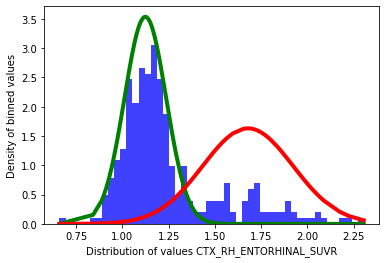

In [14]:
dict_figures['hist_density_CTX_RH_ENTORHINAL_SUVR']

The keys in the dictionary follow the same convention regardless of the type:

`hist_TYPE_REGION`

````{admonition} Advanced topic: Generating individual histograms

Because of the way `sihnpy` is coded, the histogram function will only output graphs for **ALL** brain regions included in the models. This can be time and space consuming, particularly if you have a high number of regions. In such cases, you should reconsider running the histograms at once for all regions.

There are a couple of workarounds to avoid doing this.

First, you can feed the `spex.gmm_histograms` function reduced dataframes. If you subset your `final_data` dataframe, your `gmm_measures` and your `probs_df` to contain only a subset of columns, histograms will only be generated for these regions. The only important detail is that **the name of the columns in the `final_data` you feed to function can be found in the `gmm_measures` dictionary.** From there, it is up to you to decide what regions to keep.

Second, for more flexibility (e.g., if you don't like the colors `sihnpy` uses or want to modify the axis labels), you can create the histograms yourself with relative ease. Below are some sample code that `sihnpy` uses to generate each type of histogram

**Raw data and probability histograms**

These graphs require little work.

```python
fig = plt.figure() #Instantiate figure
plt.hist(regional_data, bins=50, density=False, facecolor='b', alpha=0.75) #Dataframe column with the data you want to plot
plt.xlabel("YOUR_LABEL_HERE")
plt.ylabel("YOUR_LABEL_HERE")
```

All options given to `plt.hist()` can be modified up to your preferences.

**Density histograms**

These graphs are slightly more tricky. To generate the curves, we need to leverage `scipy.stats` and we need to tell it what is the average and standard deviation of each distribution we want to plot. We also use `numpy` for some basic data cleaning.

```python
fig = plt.figure() #Instantiate figure
plt.hist(regional_data, bins=50, density=True, facecolor='b', alpha=0.75) #Note we force `density=True`
plt.plot(np.sort(regional_data), stats.norm.pdf(np.sort(regional_data),
                                                average_clust_1,
                                                sd_clust_1),
        color='green', linewidth=4)
plt.plot(np.sort(regional_data), stats.norm.pdf(np.sort(regional_data),
                                                average_clust_2,
                                                sd_clust_2),
        color='red', linewidth=4)
plt.xlabel("YOUR_LABEL_HERE")
plt.ylabel("YOUR_LABEL_HERE")
```

The key for the plots here is to set the histogram to being displayed as **density** (`density=True`) and then using `scipy.stats` to generate the distribution for each cluster. In `sihnpy`, you get the average and standard deviation of each cluster at the `spex.gmm_measures` step, but you can feed it any sort of average and SD as a float.

Also note that while the histogram function will automatically sort the data before plotting, the density function for the curves will not. This can give pretty funky curves as shown below:

IMAGE OF DENSITY WITHOUT SORTING

**Exporting the histograms**

{ref} `As we will see soon <2.spex/spex_module:Exporting the threshold data>`, `sihnpy` also has a function allowing us to export the histograms to file. As long as you save your histograms made individually in a dictionary, you will be able to use `sihnpy`'s function to export all the histograms at once.

````

````{admonition} Advanced topic: Plotting a single density function instead of two

Across the module, we mention that `sihnpy` runs on the assumption that there are two clear distributions in the data. While we verify this with the BIC at the `spex.gmm_estimation` step, this is not always a foolproof measure. Also, it is always nice to plot data in case of doubt. You can always just look at the raw data histogram, but you can also output a single 

Thankfully, `sihnpy` also allows you to use the `spex.gmm_histogram` function to plot a single distribution instead of two, by setting the `dist_2` option to `False`. For instance, if you ran a GMM with only 1 component, you can extract the mean and standard deviation of that distribution, and use it in the function. The only downside is that `sihnpy` doesn't currently output the GMM measures for the 1 cluster solution, and as such, the other functions like `spex.gmm_measures` won't work, even though you need that function to run `spex.gmm_histograms`.

My main workaround for now is to run the GMM and extract its mean and standard deviation outside of `sihnpy`. Then, you would simply need to store these values in a nested dictionary, where the first level is the region of interest (matching the column in the data) and the second level contains a `mean_comp1` and a `sd_comp1` variables with their values. 

```python
test_dictionary['REGION_OF_INTEREST'] = {"mean_comp1":1.3777, "sd_comp1":0.256}
```

This could probably be better optimized... but for now that's how it works.

````

#### 6. Threshold derivation

Once everything has been calculated and histograms have been checked (if needed), you can then proceed to the last important step: **generating the thresholds for each region**.

I've {ref}`detailed the actual rationale behind the method before <2.spex/spex_module:Introduction to Gaussian mixture modelling (GMM)>`, but just as a refresher, the goal here is to determine a **probability threshold** that we conclude that a participant is **probably abnormal**. Once that is established, we simply transform that probability back to our original unit (in the case of the simulated data, the unit is in SUVR) by finding the participant **closest to the probability threshold, and using their SUVR as the threshold**.

The code is quite easy to apply: we just need the `final_data` (SUVR data) and the `probability_data` for our participants. We then need to decide how many thresholds we want to apply to the data.

In [15]:
thresholds = spex.gmm_threshold_deriv(final_data=final_data, probs_df=probability_data, prob_threshs=[0.5, 0.9])
thresholds

,thresh_0.5,thresh_0.9
CTX_LH_ENTORHINAL_SUVR,1.338935,1.435800
CTX_RH_ENTORHINAL_SUVR,1.385862,1.469123
CTX_LH_AMYGDALA_SUVR,1.429867,1.527259
CTX_RH_AMYGDALA_SUVR,1.372292,1.457656
CTX_LH_FUSIFORM_SUVR,1.464357,0.759502
CTX_RH_FUSIFORM_SUVR,1.392690,1.457191
CTX_LH_PARAHIPPOCAMPAL_SUVR,1.313140,1.399550
CTX_RH_PARAHIPPOCAMPAL_SUVR,1.291010,1.367509
CTX_LH_INFERIORTEMPORAL_SUVR,0.762055,1.622339
CTX_RH_INFERIORTEMPORAL_SUVR,1.387419,1.470146


And that's it! We now have our thresholds. You can decide on how many thresholds you would like: it is really up to you and your research question. It also depends on whether you want to compute a spatial extent index, as more thresholds will add complexity.

(ADD REFS IN PREVIOUS PARAGRAPHS)

But wait... do you notice something wrong in the thresholds we get?

```{admonition} Fix: Fixing improbable thresholds
:class: warning

As you might have noticed, three thresholds don't seem to look very different from the rest in the data: the 50% probability threshold of the left inferior and middle temporal gyri and the 90% probability threshold for the left fusiform gyrus. The first two are much lower than the others in their category, and the 90% probability for the fusiform gyrus is lower than the 50% threshold. That doesn't make sense...

Let's look at a histogram to understand.

ADD HISTOGRAM HERE

In the histogram above, we see an example from the left entorhinal cortex. The COLOR arrow represents where approximately the 50% threshold should be, while the COLOR arrow represents where approximately the 90% threshold should be. Now let's look at, the results from the left fusiform gyrus.

ADD HISTOGRAM HERE

Looking at the data, it is more like our 90% probability falls at the COLOR arrow. Why is that?

Well it turns out that when the distribution of your second cluster is quite spread out, with some data points at the extreme low end, the GMM classifies **ALL** the outliers together, including the extremely low data. As a reminder, the GMM attributes a probability that each value belongs to the "abnormal" distribution. In this case, the GMM considered that the extremely low points were so different from the "normal" distribution that it definitely belong to the "abnormal" distribution, and through chance, the probability closest to 90% was attributed to one of the participants to the lower end. However, keeping the threshold as is would mean that almost the entirety of the sample would be classified as abnormal, which would be innacurate and would also bias the spatial extent index we will compute.

So how do we fix this?

For now, `sihnpy` allows you to set a value below which it would be impossible that a participant would be positive. This is slightly arbitrary and will depend on your data. Looking at the histogram above and the literature on SUVR data, it will be pretty much impossible that values for a threshold fall below 1.0. We can therefore ask `sihnpy` to look for the closest value, ignoring values falling below a certain threshold. We do this using the `improb` argument.

```

In [16]:
thresholds = spex.gmm_threshold_deriv(final_data=final_data, probs_df=probability_data, prob_threshs=[0.5, 0.9], improb=1.0)
thresholds

Threshold for CTX_LH_INFERIORTEMPORAL_SUVR is improbable. Fixing.
Threshold for CTX_LH_MIDDLETEMPORAL_SUVR is improbable. Fixing.
Threshold for CTX_LH_FUSIFORM_SUVR is improbable. Fixing.


,thresh_0.5,thresh_0.9
CTX_LH_ENTORHINAL_SUVR,1.338935,1.435800
CTX_RH_ENTORHINAL_SUVR,1.385862,1.469123
CTX_LH_AMYGDALA_SUVR,1.429867,1.527259
CTX_RH_AMYGDALA_SUVR,1.372292,1.457656
CTX_LH_FUSIFORM_SUVR,1.464357,1.558444
CTX_RH_FUSIFORM_SUVR,1.392690,1.457191
CTX_LH_PARAHIPPOCAMPAL_SUVR,1.313140,1.399550
CTX_RH_PARAHIPPOCAMPAL_SUVR,1.291010,1.367509
CTX_LH_INFERIORTEMPORAL_SUVR,1.522834,1.622339
CTX_RH_INFERIORTEMPORAL_SUVR,1.387419,1.470146


These thresholds look a lot more reasonable! We can do a quick comparison to verify:

In [17]:
print(f"Number of participants positive at 0.759502 in the fusiform gyrus: {(final_data['CTX_LH_FUSIFORM_SUVR'] >= 0.759502).sum()}")
print(f"Number of participants positive at 1.558444 in the fusiform gyrus: {(final_data['CTX_LH_FUSIFORM_SUVR'] >= 1.558444).sum()}")

Number of participants positive at 0.759502 in the fusiform gyrus: 304
Number of participants positive at 1.558444 in the fusiform gyrus: 67


With the first threshold we would have 304 out of 308 people being abnormal, which is absurdly high. With the second threshold, we have 67 participants being abnormal (22%). This is a lot more close to what would be expected in this type of data.

```{tip}
Choosing a probability threshold is more of an art rather than a science. It depends on a lot of factors including previous literature, the goal of the analysis, the preference of the researcher, etc. I have a small section in the {ref}`Additional notes section <2.spex/spex_module:Additional notes>` where I talk specifically of these probability thresholds in Alzheimer's disease using PET data.

Ultimately, I don't think that there is a magic number that will fit all study designs perfectly. I would probably recommend to chose 1 main threshold, and replicate the results with other thresholds to ensure comparability.
```

#### 7. Exporting the threshold data

We are officially done deriving thresholds. Now, we can output our results to files so we can save them. `sihnpy` has two functions to do this (though they area really just simple wrappers around `matplotlib` and `pandas`). The first one saves any and all histograms generated by the `spex.gmm_histograms` function and the other saves the `final_data` (data with columns removed if `fix` was used), `probability_data` generated by the `spex.gmm_probs` function and the `thresholds` we just derived using `spex.gmm_threshold_deriv`. 

Other than the objects we need to export, `sihnpy` also needs the path on your computer where it can output these data and it needs a `name` to give to the file. This is more for the user to choose how to name the files, as running the function multiple times in a row might erase previous versions.

Here is the code sample to accomplish this:

```python
spex.export_histograms(dict_figures, "/local/path/to/file", "test")
spex.export_threshs(final_data, probability_data, thresh_df, "/local/path/to/file", "test")
```

Congrats! You are done with the **Derive** section of the spatial extent.

### Introduction to pre-determined (normative sample) thresholds

GMM is not your style? Or you have a specific sample in mind as a reference group that you want to use to create the spatial extent? You can still use `sihnpy` to meet your needs! In the first section on the GMM, I talk about {ref}`obtaining data from the datasets module <2.spex/spex_module:1. Get the data`, for which the code looks like this:

In [18]:
from sihnpy import datasets

tau_data, regional_thresholds, regional_averages = datasets.pad_spex_input()
regional_thresholds

,threshold_3SD
region,
CTX_LH_ENTORHINAL_SUVR,1.449
CTX_RH_ENTORHINAL_SUVR,1.419
CTX_LH_AMYGDALA_SUVR,1.521
CTX_RH_AMYGDALA_SUVR,1.508
CTX_LH_FUSIFORM_SUVR,1.533
CTX_RH_FUSIFORM_SUVR,1.409
CTX_LH_PARAHIPPOCAMPAL_SUVR,1.382
CTX_RH_PARAHIPPOCAMPAL_SUVR,1.328
CTX_LH_INFERIORTEMPORAL_SUVR,1.595


One of the objects returned by `datasets.pad_spex_input()` is `regional_thresholds`. This data simulates thresholds that we would have already derived in advance. In this case, the threshold corresponds to 3 standard deviation above the average of the first GMM cluster. In the Alzheimer's disease literature, this method is frequently used to derive thresholds. [^Villeneuve_2015] For instance, we know young adults do not present amyloid and tau signal on PET, and as such, their SUVR values are often used as reference to derive thresholds. You could also use a different patient group as control for instance.

The rest of the spatial extent module simply applies the regional threshold we have to our data. As long as the file containing the thresholds match what `sihnpy` is expecting (regions in the thresholds file match column names in the data, 1 column per type of threshold, etc.), any thresholds derived out of `sihnpy` can be used to apply the spatial extent.


## Applying thresholds

This step is far easier than deriving the thresholds. If you made it here, you are almost done!

Note that I will be demonstrating the functions below with the output from the GMM only. The steps are identical if you use the `regional_thresholds` output from `datasets.pad_spex_input()` (and it's been tested, so it should work on your end too!).

### 1. Clean data

The first step when applying the thresholds to the data is to clean the dataframe where we have the thresholds, and the dataframe where we have data we want to threshold. We basically just make sure that the brain regions are the same between the two data and that both datasets are formatted appropriately for what `sihnpy` is expecting, which is:

1) The data is in a `pandas.DataFrame` object, where the rows are the participants and columns are the name of the regions
2) The thresholds are in a `pandas.DataFrame` object, where the rows are the name of the regions and the columns are the thresholds
3) The naming of the regions are matching between both objects

Let's run the function with the thresholds we found using the GMM method:

In [19]:
data_to_apply_clean, thresh_data_clean = spex.apply_clean(data_to_apply=final_data, thresh_data=thresholds)
data_to_apply_clean

,CTX_LH_AMYGDALA_SUVR,CTX_LH_ENTORHINAL_SUVR,CTX_LH_FUSIFORM_SUVR,CTX_LH_INFERIORTEMPORAL_SUVR,CTX_LH_MIDDLETEMPORAL_SUVR,CTX_LH_PARAHIPPOCAMPAL_SUVR,CTX_LH_POSTCENTRAL_SUVR,CTX_LH_PRECENTRAL_SUVR,CTX_RH_AMYGDALA_SUVR,CTX_RH_ENTORHINAL_SUVR,CTX_RH_FUSIFORM_SUVR,CTX_RH_INFERIORTEMPORAL_SUVR,CTX_RH_MIDDLETEMPORAL_SUVR,CTX_RH_PARAHIPPOCAMPAL_SUVR
participant_id,,,,,,,,,,,,,,
sub-5458966,1.006147,1.111972,1.322257,1.200685,1.136680,0.856778,0.964623,0.836766,1.330316,1.120199,1.208377,1.170536,1.167629,1.149150
sub-2424540,1.118358,1.279463,1.064330,1.143115,1.189367,0.939988,0.903880,1.008217,1.176036,1.238721,1.203981,1.354172,1.305499,0.965154
sub-7855613,1.133187,1.165918,1.057046,1.188624,1.178537,0.919426,1.039233,0.994861,1.239481,1.074124,1.072006,1.213766,1.122608,1.051297
sub-3137570,1.003114,1.057761,0.950004,1.127921,1.007086,1.173269,0.985742,0.906591,1.225939,1.058959,1.283570,1.106209,1.103633,1.108080
sub-9650197,1.214722,1.115381,1.346469,1.176183,1.016241,1.009351,0.861014,1.058830,1.359531,1.106487,1.111211,1.283605,1.170783,1.172829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-5336241,1.892483,1.755116,2.088089,1.587848,1.338308,1.021844,0.558954,0.698112,0.914250,1.791774,1.693487,2.456752,1.571080,1.371482
sub-1002928,1.567078,1.725995,2.359009,2.517382,1.536081,1.314826,0.985675,1.442845,1.379281,1.665045,1.743699,1.227152,1.932241,1.472280
sub-1283278,1.831518,1.763810,1.960012,2.390055,1.372247,1.729197,0.910037,1.039855,1.901642,1.557945,2.085522,2.020771,1.800840,1.458530


In [20]:
thresh_data_clean

,thresh_0.5,thresh_0.9
CTX_LH_AMYGDALA_SUVR,1.429867,1.527259
CTX_LH_ENTORHINAL_SUVR,1.338935,1.435800
CTX_LH_FUSIFORM_SUVR,1.464357,1.558444
CTX_LH_INFERIORTEMPORAL_SUVR,1.522834,1.622339
CTX_LH_MIDDLETEMPORAL_SUVR,1.439846,1.562897
CTX_LH_PARAHIPPOCAMPAL_SUVR,1.313140,1.399550
CTX_LH_POSTCENTRAL_SUVR,1.203612,1.282258
CTX_LH_PRECENTRAL_SUVR,1.139848,1.203600
CTX_RH_AMYGDALA_SUVR,1.372292,1.457656
CTX_RH_ENTORHINAL_SUVR,1.385862,1.469123


Everything seems ok! `sihnpy` did a quick cleaning: it filtered rows of the thresholds dataset with so that it matches the columns available in the data, and it filtered the columns of the data so that it matches the thresholds available.

You might also notice that the order of the columns in the data and the order of the rows in the thresholds changed. This is because `sihnpy` also reordered them so that they have the same order.

```{warning}
While this function is relatively simple, it is critical for the next steps. **If the regions are not ordered in the same, it will cause thresholds of one region to be applied to data in another region.**
```

### 2. Binary masks

The next step is the application of the thresholds to the data (see, I did say you were almost done!). In a nutshell, `sihnpy` takes your dataset, applies the thresholds to each region and returns a `pandas.DataFrame` of identical dimension, **but with a binary output instead**.

When you have multiple thresholds, `sihnpy` will create a mask for each threshold, and save it in a dictionary. This can be useful when you want the masks to be kept separately (and it also simplified my life in terms of coding this...)

In [21]:
dict_masks = spex.apply_masks(data_to_apply_clean=data_to_apply_clean, thresh_data_clean=thresh_data_clean)
dict_masks['thresh_0.5'] #Or replace by 'thresh_0.9' if you want to see the other one

,CTX_LH_AMYGDALA_SUVR,CTX_LH_ENTORHINAL_SUVR,CTX_LH_FUSIFORM_SUVR,CTX_LH_INFERIORTEMPORAL_SUVR,CTX_LH_MIDDLETEMPORAL_SUVR,CTX_LH_PARAHIPPOCAMPAL_SUVR,CTX_LH_POSTCENTRAL_SUVR,CTX_LH_PRECENTRAL_SUVR,CTX_RH_AMYGDALA_SUVR,CTX_RH_ENTORHINAL_SUVR,CTX_RH_FUSIFORM_SUVR,CTX_RH_INFERIORTEMPORAL_SUVR,CTX_RH_MIDDLETEMPORAL_SUVR,CTX_RH_PARAHIPPOCAMPAL_SUVR
participant_id,,,,,,,,,,,,,,
sub-5458966,0,0,0,0,0,0,0,0,0,0,0,0,0,0
sub-2424540,0,0,0,0,0,0,0,0,0,0,0,0,0,0
sub-7855613,0,0,0,0,0,0,0,0,0,0,0,0,0,0
sub-3137570,0,0,0,0,0,0,0,0,0,0,0,0,0,0
sub-9650197,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-5336241,1,1,1,1,0,0,0,0,0,1,1,1,1,1
sub-1002928,1,1,1,1,1,1,0,1,1,1,1,0,1,1
sub-1283278,1,1,1,1,0,1,0,0,1,1,1,1,1,1


So we now see a dataframe, with 308 rows and 14 columns, the same as we had at the previous step, but now it is filled with 0s and 1s. Perfect. While `sihnpy` is being tested to make sure the output of this code matches your input, you can also test it yourself relatively easily. For instance, let's say we want to make sure we have the right amount of people that are positive in the left amygdala. You would simply need the following line:

In [22]:
print((final_data['CTX_LH_AMYGDALA_SUVR'] >= 1.429867).sum()) #Yields 72
print((dict_masks['thresh_0.5']['CTX_LH_AMYGDALA_SUVR']).sum()) #Yields 72

72
72


It matches! So we are good to go.

Actually, depending on your needs, you could stop here. You have effectively applied thresholds to you data, and it resulted in masks of binary data. The next two steps propose some extra mesures that you can use in your study.

### 3. Spatial extent index

The crown jewel of this module (and its namebearer) comes from this metric we developped that we termed **spatial extent index**. What this measure boils down to is simply a count of **how many regions are abnormal for each participant**. That's it. A simple sum of regions that are abnormal, for each participant, in a single `pandas.DataFrame`.

In cases where you have more than 1 threshold for your data, `sihnpy` will output one spatial extent index for each threshold AND a sum of the spatial extent indices together. More on why this might be useful in a little bit. For now, let's compute our spatial extent indices.

In [23]:
spex_metrics = spex.apply_index(data_to_apply_clean=data_to_apply_clean, dict_masks=dict_masks)
spex_metrics

,spatial_extent_thresh_0.5,spatial_extent_thresh_0.9,spatial_extent_sum_all
participant_id,,,
sub-5458966,0,0,0
sub-2424540,0,0,0
sub-7855613,0,0,0
sub-3137570,0,0,0
sub-9650197,0,0,0
...,...,...,...
sub-5336241,9,8,17
sub-1002928,12,9,21
sub-1283278,11,11,22


Cool! So each column of the `spex_metrics` object is a spatial extent index. Remember, the spatial extent index is capped at the number of regions you have in your data. So both `spatial_extent_thresh_0.5` and `spatial_extent_thresh_0.9` can each go to a maximum of 14 (14 regions are kept in the end, with 14 thresholds available).

```{admonition} Advanced topic: The sum of spatial extents and its potential use
:class: danger

As we see above, `sihnpy` outputs a sum of the spatial extent indices. Why is that? Let's take a look at one participant in the dataframe printed above: `sub-1002928`

As we can see, this participant has 12 region being abnormal at a 50% probability threshold, but only 9 at a 90% probability threshold. This can be interesting for us, as it highlights a grey zone of **borderline** cases. This opens a lot of possibility (e.g., looking at participants in this borderline zone, for instance).

`sihnpy` outputs a sum of all spatial extent indices threshold together. This is perhaps not the most... indicative measure, but it allows a bit more granularity in the final spatial extent measure, particularly in the next step on {ref}`individualized spatial extent masks <2.spex/spex_module:4. Individualized spatial extent masks>`.
```

### 4. Individualized spatial extent masks

The spatial extent index is a global measure (well, global depending on the regions you put in I guess), which transforms the original data to a simple sum of regions across the brain. This is a great summary measure. However, sometimes, you may want to keep your measures with the original units. You may also want to keep the regions separated in your measure (instead of aggregating them in a single sum).

This is where the individualized spatial extent masks come in. Basically, since the binary masks we computed in the {ref}`second step <2.spex/spex_module:2. Binary masks>` have the same index and columns as our original data, we can simply multiply the two `pandas.DataFrame` together. For instance, if a participant is negative in a region, the multiplication would yield a 0. Instead if a participant is positive in a region, the multiplication would return the original value from the data (since we multiplied it by 1).

Let's take a look at what this looks like in practice

In [25]:
spex_ind_masks = spex.apply_ind_mask(data_to_apply_clean=data_to_apply_clean, dict_masks=dict_masks)
spex_ind_masks['thresh_0.5']

,CTX_LH_AMYGDALA_SUVR,CTX_LH_ENTORHINAL_SUVR,CTX_LH_FUSIFORM_SUVR,CTX_LH_INFERIORTEMPORAL_SUVR,CTX_LH_MIDDLETEMPORAL_SUVR,CTX_LH_PARAHIPPOCAMPAL_SUVR,CTX_LH_POSTCENTRAL_SUVR,CTX_LH_PRECENTRAL_SUVR,CTX_RH_AMYGDALA_SUVR,CTX_RH_ENTORHINAL_SUVR,CTX_RH_FUSIFORM_SUVR,CTX_RH_INFERIORTEMPORAL_SUVR,CTX_RH_MIDDLETEMPORAL_SUVR,CTX_RH_PARAHIPPOCAMPAL_SUVR
participant_id,,,,,,,,,,,,,,
sub-5458966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-2424540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-7855613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-3137570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-9650197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-5336241,1.892483,1.755116,2.088089,1.587848,NaN,NaN,NaN,NaN,NaN,1.791774,1.693487,2.456752,1.571080,1.371482
sub-1002928,1.567078,1.725995,2.359009,2.517382,1.536081,1.314826,NaN,1.442845,1.379281,1.665045,1.743699,NaN,1.932241,1.472280
sub-1283278,1.831518,1.763810,1.960012,2.390055,NaN,1.729197,NaN,NaN,1.901642,1.557945,2.085522,2.020771,1.800840,1.458530


As you can see, for many participants, there is a missing value, indicating that the SUVR value is 0 in that region. For those with abnormal regions, we see their SUVR region from the `final_data` object. For instance, the SUVR of `sub-6261459` in left amygdala should match the information we just computed

In [28]:
print(final_data.loc['sub-6261459', "CTX_LH_AMYGDALA_SUVR"])
print(spex_ind_masks['thresh_0.5'].loc['sub-6261459', 'CTX_LH_AMYGDALA_SUVR'])

1.9117029907873224
1.9117029907873224


That works! We now have an additional measure, but this time in the units of the original data.

```{admonition} Advanced topic: Spatial extent weighted individualized masks
:class: danger

Remember when I mentioned that the sum of spatial extent might become useful here too? Here's why.

When multiple thresholds are used, we know that there is a difference in how certain we are of a given threshold (e.g., we are more certain that a given region is abnormal if the algorithm tells us that there is a 90% probability that it belongs to the abnormal distribution, compared to 50%). With this in mind, you can give different **weights** to regions, where a region with a higher probability of being abnormal **weighs more**.

Be default, when you have more than one threshold, `sihnpy` will automatically compute a weighted mask. The mask is simply weighted by multiplying the value in a given region **by the number of thresholds it passes**. 

For example, let's imagine that a 50% probability threshold is set at 1.3 for a region, and a 90% probability threshold is set at 1.4. If the region has a value of 1.2, the weight will be 0, so the final value will also be 0 (i.e., the region is not considered abnormal). If the region has a value of 1.3, it passes one threshold, so its final weight is 1 (i.e., the value in that region will be equal to the original data, meaning 1.3). If the region has a value of 1.5, it means it passes both thresholds and its final weight is 2 (i.e., the final value in that region will be 3.0). Simply be mindful that the final units you obtain from this method **can no longer be interpreted in the original scale of the data**.

This weighing system is quite rudimentary, and I am happy to consider other methods. Just let me know by opening an [issue on Github](https://github.com/stong3/sihnpy/issues).

Below is an example of the weighted mask. Notice how the value for `sub-6261459` is now 3.823406, which is double the original value?
```

In [29]:
spex_ind_masks['mask_spatial_extent_sum_all']

,CTX_LH_AMYGDALA_SUVR,CTX_LH_ENTORHINAL_SUVR,CTX_LH_FUSIFORM_SUVR,CTX_LH_INFERIORTEMPORAL_SUVR,CTX_LH_MIDDLETEMPORAL_SUVR,CTX_LH_PARAHIPPOCAMPAL_SUVR,CTX_LH_POSTCENTRAL_SUVR,CTX_LH_PRECENTRAL_SUVR,CTX_RH_AMYGDALA_SUVR,CTX_RH_ENTORHINAL_SUVR,CTX_RH_FUSIFORM_SUVR,CTX_RH_INFERIORTEMPORAL_SUVR,CTX_RH_MIDDLETEMPORAL_SUVR,CTX_RH_PARAHIPPOCAMPAL_SUVR
participant_id,,,,,,,,,,,,,,
sub-5458966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-2424540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-7855613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-3137570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-9650197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-5336241,3.784965,3.510231,4.176179,1.587848,NaN,NaN,NaN,NaN,NaN,3.583547,3.386974,4.913504,3.142160,2.742964
sub-1002928,3.134157,3.451991,4.718017,5.034764,1.536081,1.314826,NaN,2.885691,1.379281,3.330090,3.487399,NaN,3.864482,2.944559
sub-1283278,3.663036,3.527620,3.920024,4.780110,NaN,3.458394,NaN,NaN,3.803285,3.115889,4.171044,4.041542,3.601679,2.917060


### 5. Exporting the data

The last part to worry about is simply to export the data we just computed. Fortunately, `sihnpy` already has functions for that. As I mention {ref}`before <2.spex/spex_module:7. Exporting the threshold data>`, these functions are mostly wrappers around existing functions from `pandas`. The main difference is that exporting data this way ensures a consistent naming, and `sihnpy` will output any and all masks created during that step (i.e., no need to export dictionary items yourself).

There are three functions to export here: `spex.export_spex_metrics` (exports spatial extent indices), `spex.export_spex_bin_masks` (exports the binary masks for each individual thresholds) and `spex.export_ind_masks` (exports individualized spatial extent masks).

```python
spex.export_spex_metrics(spex_metrics=spex_metrics, output_path="/local/path/to/file", name="test")
spex.export_spex_bin_masks(dict_masks=dict_masks, output_path="/local/path/to/file", name="test")
spex.export_spex_bin_masks(spex_ind_masks=spex_ind_masks, output_path="/local/path/to/file", name="test")
```

Once again, the `name` argument is up to your preferences, as long as you make sense of it. It will be appended to the end of the file names.

## tl;dr

Made it all the way to the end? Or you just skipped ahead to get the functions you want? Here is a quick summary of all the functions together:

```python
import pandas as pd #For some extra manipulations, if needed
from sihnpy import datasets #For simulated data
from sihnpy import spatial_extent as spex #For spatial extent module

#Prepare data
tau_data, regional_thresholds, regional_averages = datasets.pad_spex_input() #Imports simulated data if you need data
tau_data.drop(labels=["sex", "test_language", "handedness_score", "handedness_interpretation"], axis=1, inplace=True) #Clean the data

#Derive the thresholds with the spatial extent
#Don't forget to decide if you need/want the fix argument set to `True` or `False` in these functions.
#Below are the recommended fixing options.
gm_estimations, clean_data = spex.gmm_estimation(data_to_estimate=tau_data, fix=True) #Estimate the GMM (2 components)
final_data, final_gm_dict, gmm_measures = spex.gmm_measures(cleaned_data=clean_data, gm_objects=gm_estimations, fix=True) #Compute measures of each cluster and clean data
probability_data = spex.gmm_probs(final_data=final_data, final_gm_estimations=final_gm_estimations, fix=False) #Computes abnormality probability for each sample.
dict_figures = spex.gmm_histograms(final_data=final_data, gmm_measures=gmm_measures, probs_df=probability_data, type="density") # (Optional) Outputs histograms of the densities for each cluster
thresh_df = spex.gmm_threshold_deriv(final_data=final_data, probs_df=probability_data, prob_threshs=[0.5, 0.9], improb=1.0) #Derive thresholds based on probability.
#Don't forget to set an "improbable" value based on your data, if applicable.

#Apply the thresholds
data_to_apply_clean, thresh_data_clean = spex.apply_clean(data_to_apply=final_data, thresh_data=thresh_df) #Basic clean-up and reordering
dict_masks = spex.apply_masks(data_to_apply_clean=data_to_apply_clean, thresh_data_clean=thresh_data_clean) #Create binary masks from thresholds
spex_metrics = spex.apply_index(data_to_apply_clean=data_to_apply_clean, dict_masks=dict_masks) #Computes spatial extent index
spex_ind_masks = spex.apply_ind_mask(data_to_apply_clean=data_to_apply_clean, dict_masks=dict_masks) #Computes individualized spatial extent masks

#Export all the data computed
spex.export_histograms(dict_figures, "/local/path/to/file", "test") #Export histograms, if done at the derive step
spex.export_threshs(final_data, probability_data, thresh_df, "/local/path/to/file", "test") #Export clean data before applying thresholds, probability data and the thresholds

spex.export_spex_metrics(spex_metrics=spex_metrics, output_path="/local/path/to/file", name="test") #Export spatial extent indices
spex.export_spex_bin_masks(dict_masks=dict_masks, output_path="/local/path/to/file", name="test") #Export binary masks of abnormality
spex.export_spex_bin_masks(spex_ind_masks=spex_ind_masks, output_path="/local/path/to/file", name="test") #Export individualized spatial extent masks
```

Thanks for reading!